# JHU JSALT Summer School IR Laboratory -- Part 2 (extra)

This notebook is mainly borrowed from the series of Colab notebooks created for the [CIKM 2021](https://www.cikm2021.org/) Tutorial entitled '**IR From Bag-of-words to BERT and Beyond through Practical Experiments**'. For more information, please visit their [repository](https://github.com/terrier-org/cikm2021tutorial).

In particular, in this notebook you will:

 - Re-rank documents using neural models like KNRM, Vanilla BERT, EPIC, and monoT5.
 - Use DeepCT and doc2query to augment documents for lexical retrieval functions like BM25.

## Setup

In the following, we will set up the libraries required to execute the notebook.

### Pyterrier installation

The following cell installs the latest release of the [PyTerrier](https://github.com/terrier-org/pyterrier) package.

In [1]:
!pip install -q --upgrade python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.p

### Pyterrier plugins installation

We install the [OpenNIR](https://opennir.net/) and [monoT5](https://github.com/terrierteam/pyterrier_t5) PyTerrier plugins. You can safely ignore the package versioning errors.

In [2]:
!pip install -q --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR
!pip install -q --upgrade git+https://github.com/terrierteam/pyterrier_t5

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.3/114.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## Preliminary steps

**[PyTerrier](https://github.com/terrier-org/pyterrier) initialization**

Lets get [PyTerrier](https://github.com/terrier-org/pyterrier) started. This will download the latest version of the [Terrier](http://terrier.org/) IR platform. We also import the [OpenNIR](https://opennir.net/) pyterrier bindings.

In [7]:
import pyterrier as pt
if not pt.started():
    pt.init()
from pyterrier.measures import * # allow for natural measure names
import onir_pt

terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


### [TREC-COVID19](https://ir.nist.gov/covidSubmit/) Dataset download

The following cell downloads the [TREC-COVID19](https://ir.nist.gov/covidSubmit/) dataset that we will use in the remainder of this notebook.

In [8]:
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = dataset.get_topics(variant='description')
qrels = dataset.get_qrels()

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: s] [18.7kB] [26.6MB/s]
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [1.39s] [1.14MB] [824kB/s]


### Terrier inverted index download

To save a few minutes, we use a pre-built Terrier inverted index for the TREC-COVID19 collection ([`'terrier_stemmed'`](http://data.terrier.org/trec-covid.dataset.html#terrier_stemmed) version). Download time took a few seconds for us.

In [9]:
index = pt.get_dataset('trec-covid').get_index('terrier_stemmed_positions')

data.meta.zdata:   0%|          | 0.00/4.38M s<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/1.46M s<?, ?iB/s]

data.properties:   0%|          | 0.00/4.37k s<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/5.29M s<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/48.7M s<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/14.2M s<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/619k s<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k s<?, ?iB/s]

md5sums:   0%|          | 0.00/537 s<?, ?iB/s]

data.direct.bf:   0%|          | 0.00/50.6M s<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/4.56M s<?, ?iB/s]

## Re-Rankers from scratch

Let's start exploring a few neural re-ranking methods! We can build them from scratch using `onir_pt.reranker`.

And OpenNIR reranking model consists of:
 - `ranker` (e.g., `drmm`, `knrm`, or `pacrr`). This defines the neural ranking architecture.
 - `vocab` (e.g., `wordvec_hash`, or `bert`). This defines how text is encoded by the model. This approach makes it easy to swap out different text representations.

This line will take a few minutes to run as it downloads and prepares the word vectors.

In [10]:
knrm = onir_pt.reranker('knrm', 'wordvec_hash', text_field='title_abstract')

config file not found: config
[2024-06-02 02:04:31,998][WordvecHashVocab][DEBUG] [starting] downloading https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


[2024-06-02 02:04:47,679][onir.util.download][WARNING] no hash provided for https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip; consider adding expected_md5="3cc8839ac3fa9a6187149b1e73328b2a" to ensure data integrity.
[2024-06-02 02:04:47,686][onir.util.download][DEBUG] downloaded https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip [15.25s] [682M] [50.1MB/s]
[2024-06-02 02:04:47,694][WordvecHashVocab][DEBUG] [finished] downloading https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip [15.70s]
[2024-06-02 02:04:47,694][WordvecHashVocab][DEBUG] [starting] extracting vecs
[2024-06-02 02:05:03,724][WordvecHashVocab][DEBUG] [finished] extracting vecs [16.03s]
[2024-06-02 02:05:03,724][WordvecHashVocab][DEBUG] [starting] loading vecs into memory
[2024-06-02 02:07:26,506][WordvecHashVocab][DEBUG] [finished] loading vecs into memory [02:23]
[2024-06-02 02:07:26,852][WordvecHashVocab][DEBUG] [starting] writ

Let's look at how well these models work at ranking!

In [11]:
br = pt.BatchRetrieve(index) % 50
# build a sub-pipeline to get the concatenated title and abstract text
get_title_abstract = pt.text.get_text(dataset, 'title') >> pt.text.get_text(dataset, 'abstract') >> pt.apply.title_abstract(lambda r: r['title'] + ' ' + r['abstract'])
pipeline = br >> get_title_abstract >> knrm
pt.Experiment(
    [br, pipeline],
    topics,
    qrels,
    names=['DPH', 'DPH >> KNRM'],
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10]
)

02:08:32.769 [main] WARN org.terrier.structures.FSADocumentIndex - This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 s<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M s<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.1%| 279k/269M s<02:12, 2.04MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.7%| 1.79M/269M s<37.08s, 7.21MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 3.1%| 8.33M/269M s<11.29s, 23.1MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazon

[2024-06-02 02:09:03,181][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:09:03,791][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/625 s<?, ?it/s]

[2024-06-02 02:09:06,507][onir_pt][DEBUG] [finished] batches: [2.72s] [625it] [230.18it/s]


,name,AP(rel=2),nDCG,nDCG@10,P(rel=2)@10
0,DPH,0.051738,0.126191,0.642340,0.548
1,DPH >> KNRM,0.039563,0.111871,0.429542,0.370


This doesn't work very well because the model is not trained; it's using random weights to combine the scores from the similarity matrix.

## Loading a trained re-ranker

You can train re-ranking models in PyTerrier using the `fit` method. This takes a bit of time, so we'll download a model that's already been trained. If you'd like to train the model yourself, you can use:

```python
# transfer training signals from a medical sample of MS MARCO
from sklearn.model_selection import train_test_split
train_ds = pt.datasets.get_dataset('irds:msmarco-passage/train/medical')
train_topics, valid_topics = train_test_split(train_ds.get_topics(), test_size=50, random_state=42) # split into training and validation sets

# Index MS MARCO
indexer = pt.index.IterDictIndexer('./terrier_msmarco-passage')
tr_index_ref = indexer.index(train_ds.get_corpus_iter(), fields=('text',), meta=('docno',))

pipeline = (pt.BatchRetrieve(tr_index_ref) % 100 # get top 100 results
            >> pt.text.get_text(train_ds, 'text') # fetch the document text
            >> pt.apply.generic(lambda df: df.rename(columns={'text': 'abstract'})) # rename columns
            >> knrm) # apply neural re-ranker

pipeline.fit(
    train_topics,
    train_ds.get_qrels(),
    valid_topics,
    train_ds.get_qrels())
```

In [12]:
del knrm # free up the memory before loading a new version of the ranker
knrm = onir_pt.reranker.from_checkpoint('https://macavaney.us/knrm.medmarco.tar.gz', text_field='title_abstract', expected_md5="d70b1d4f899690dae51161537e69ed5a")

[2024-06-02 02:09:19,537][onir.util.download][DEBUG] downloaded https://macavaney.us/knrm.medmarco.tar.gz s] [1.43k] [7.21MB/s] [md5 hash verified]
[2024-06-02 02:09:19,552][WordvecHashVocab][DEBUG] [starting] reading cached at /root/data/onir/vocab/wordvec_hash/fasttext-wiki-news-300d-1M.p
[2024-06-02 02:09:28,610][WordvecHashVocab][DEBUG] [finished] reading cached at /root/data/onir/vocab/wordvec_hash/fasttext-wiki-news-300d-1M.p [9.06s]


In [13]:
pipeline = br >> get_title_abstract >> knrm
pt.Experiment(
    [br, pipeline],
    topics,
    qrels,
    names=['DPH', 'DPH >> KNRM'],
    baseline=0,
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10]
)

[2024-06-02 02:09:44,968][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:09:45,420][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/625 s<?, ?it/s]

[2024-06-02 02:09:46,961][onir_pt][DEBUG] [finished] batches: [1.54s] [625it] [405.89it/s]


,name,nDCG,nDCG@10,AP(rel=2),P(rel=2)@10,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,P(rel=2)@10 +,P(rel=2)@10 -,P(rel=2)@10 p-value
0,DPH,0.126191,0.642340,0.051738,0.548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DPH >> KNRM,0.123655,0.611768,0.049021,0.524,16.0,34.0,0.225167,19.0,29.0,0.299334,19.0,31.0,0.158405,19.0,22.0,0.475669


That's a little better than before, but it still underperforms our first-stage ranking model.

## Vanilla BERT

Contextualized language models, such as [BERT](https://arxiv.org/abs/1810.04805), are much more powerful neural models that have been shown to be effective for ranking.

We'll try using a "vanilla" (or "mono") version of the BERT model. The BERT model is pre-trained for the task of language modeling and next sentence prediction.

In [14]:
del knrm # clear out memory from KNRM
vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='title_abstract', vocab_config={'train': True})

100%|██████████| 231508/231508 s<0ms, 1296725.03B/s]
100%|██████████| 433/433 s<0ms, 558466.68B/s]
100%|██████████| 440473133/440473133 [9.85s<0ms, 44714366.19B/s] 


Let's see how this model does on TREC COVID.

In [15]:
pipeline = br % 50 >> get_title_abstract >> vbert
pt.Experiment(
    [br, pipeline],
    topics,
    qrels,
    names=['DPH', 'DPH >> VBERT'],
    baseline=0,
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10]
)

[2024-06-02 02:10:18,823][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:10:18,981][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/625 s<?, ?it/s]

[2024-06-02 02:11:37,760][onir_pt][DEBUG] [finished] batches: [01:19] [625it] [ 7.93it/s]


,name,nDCG,nDCG@10,AP(rel=2),P(rel=2)@10,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,P(rel=2)@10 +,P(rel=2)@10 -,P(rel=2)@10 p-value
0,DPH,0.126191,0.642340,0.051738,0.548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DPH >> VBERT,0.115140,0.478842,0.043669,0.428,12.0,38.0,0.000065,12.0,36.0,8.402604e-07,12.0,38.0,0.000178,10.0,33.0,0.000198


As we see, although the model is pre-trained, it doesn't do very well at ranking on our benchmark. This is because it's not tuned for the task of relevance ranking.

We can train the model for ranking (as shown above for KNRM) or we can download a trained model. Here, we use the [SLEDGE](https://arxiv.org/abs/2010.05987) model, which is a Vanilla BERT model trained on scientific text and tuned on medical queries.

In [16]:
sledge = onir_pt.reranker.from_checkpoint('https://macavaney.us/scibert-medmarco.tar.gz', text_field='title_abstract', expected_md5="854966d0b61543ffffa44cea627ab63b")

[2024-06-02 02:11:44,660][onir.util.download][DEBUG] downloaded https://macavaney.us/scibert-medmarco.tar.gz [6.55s] [499M] [94.8MB/s] [md5 hash verified]


[2024-06-02 02:12:08,667][onir.util.download][DEBUG] downloaded https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/pytorch_models/scibert_scivocab_uncased.tar [19.89s] [411M] [20.8MB/s] [md5 hash verified]


extracting: 411MB [1.27s, 322MB/s]
extracting: 821MB [11.14s, 73.7MB/s]


In [17]:
pipeline = br % 50 >> get_title_abstract >> sledge
pt.Experiment(
    [br, pipeline],
    topics,
    qrels,
    names=['DPH', 'DPH >> SLEDGE'],
    baseline=0,
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10, 'mrt']
)

[2024-06-02 02:12:38,894][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:12:39,039][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/625 s<?, ?it/s]

[2024-06-02 02:13:55,554][onir_pt][DEBUG] [finished] batches: [01:17] [625it] [ 8.17it/s]


,name,nDCG,nDCG@10,AP(rel=2),P(rel=2)@10,mrt,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,P(rel=2)@10 +,P(rel=2)@10 -,P(rel=2)@10 p-value
0,DPH,0.126191,0.642340,0.051738,0.548,70.295960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DPH >> SLEDGE,0.133503,0.759806,0.059288,0.672,1604.074916,37.0,13.0,0.001125,36.0,12.0,0.000384,37.0,13.0,0.002771,33.0,7.0,0.000523


That's much better! We're able to significantly improve upon the first stage ranker. But we can see that this is pretty slow to run.

## EPIC

**Some** models focus on query-time computational efficiency. The [EPIC](https://arxiv.org/abs/2004.14245) model builds light-weight document representations that are independent of the query. This means that they can be computed ahead of time. You can index the corpus yourself with the following code (but it takes a while):

```python
indexed_epic = onir_pt.indexed_epic.from_checkpoint('https://macavaney.us/epic.msmarco.tar.gz', index_path='./epic_cord19')
indexed_epic.index(dataset.get_corpus_iter(), fields=('title', 'abstract'))
```

Instead, we'll download a copy of the EPIC-processed documents:

In [18]:
import os
if not os.path.exists('epic_cord19.zip'):
  !wget http://macavaney.us/epic_cord19.zip
  !unzip epic_cord19.zip
indexed_epic = onir_pt.indexed_epic.from_checkpoint('https://macavaney.us/epic.msmarco.tar.gz', index_path='./epic_cord19')

--2024-06-02 02:13:55--  http://macavaney.us/epic_cord19.zip
Resolving macavaney.us (macavaney.us)... 172.67.183.245, 104.21.18.246
Connecting to macavaney.us (macavaney.us)|172.67.183.245|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://macavaney.us/epic_cord19.zip [following]
--2024-06-02 02:13:55--  https://macavaney.us/epic_cord19.zip
Connecting to macavaney.us (macavaney.us)|172.67.183.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548952847 (524M) [application/zip]
Saving to: ‘epic_cord19.zip’

epic_cord19.zip     100%[===================>] 523.52M  31.3MB/s    in 14s     

2024-06-02 02:14:09 (38.6 MB/s) - ‘epic_cord19.zip’ saved [548952847/548952847]

Archive:  epic_cord19.zip
   creating: epic_cord19/
  inflating: epic_cord19/dids        
 extracting: epic_cord19/_built      
  inflating: epic_cord19/data        


[2024-06-02 02:14:26,654][onir.util.download][WARNING] no hash provided for https://macavaney.us/epic.msmarco.tar.gz; consider adding expected_md5="2f6a16be1a6a63aab1e8fed55521a4db" to ensure data integrity.
[2024-06-02 02:14:26,662][onir.util.download][DEBUG] downloaded https://macavaney.us/epic.msmarco.tar.gz [5.82s] [494M] [113MB/s]


We can now run this model over the results of a first-stage ranker. Note how we do not need to fetch the document text with `pt.text.get_text`, which further saves time.

In [19]:
br = pt.BatchRetrieve(index) % 50
pipeline = (br >> indexed_epic.reranker())
pt.Experiment(
    [br, pipeline],
    dataset.get_topics('description'),
    dataset.get_qrels(),
    names=['DPH', 'DPH >> EPIC (indexed)'],
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10, "mrt"]
)

02:14:40.778 [main] WARN org.terrier.structures.FSADocumentIndex - This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored
[2024-06-02 02:14:48,935][onir_pt][INFO] This EPIC transformer shouldn't be used to calculate query latency. It computes query vectors batches (rather than individually), and doesn't do this work in parallel with first-stage retrieval. For thise operations, use the epic pipeline in OpenNIR. (This message is only shown once.)
[2024-06-02 02:14:48,936][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:14:49,267][onir_pt][DEBUG] [starting] records


/usr/local/lib/python3.10/dist-packages/onir/rankers/epic.py:107: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:621.)
  result = torch.sparse.FloatTensor(torch.stack((idx0, idx1)), tok_salience.flatten(), s)


records:   0%|          | 0/2500 s<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/onir_pt/__init__.py:670: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tids = torch.from_numpy(tids)


[2024-06-02 02:14:50,478][onir_pt][DEBUG] [finished] records: [1.21s] [2500it] [2066.49it/s]


,name,AP(rel=2),nDCG,nDCG@10,P(rel=2)@10,mrt
0,DPH,0.051738,0.126191,0.642340,0.548,77.544691
1,DPH >> EPIC (indexed),0.053531,0.126742,0.685143,0.606,98.676059


## Tuning re-ranking threshold

[Prior work suggests](https://arxiv.org/pdf/1904.12683.pdf) that the re-ranking cutoff threshold is an important model hyperparameter. Let's see how this parameter affects EPIC.

In [20]:
cutoffs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dph = pt.BatchRetrieve(index)
res = pt.Experiment(
    [dph % cutoff >> indexed_epic.reranker() for cutoff in cutoffs],
    dataset.get_topics('description'),
    dataset.get_qrels(),
    names=[f'c={cutoff}' for cutoff in cutoffs],
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10, "mrt"]
)
res

02:14:50.659 [main] WARN org.terrier.structures.FSADocumentIndex - This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored
[2024-06-02 02:14:54,150][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:14:54,183][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/500 s<?, ?it/s]

[2024-06-02 02:14:54,716][onir_pt][DEBUG] [finished] records: s] [500it] [940.64it/s]
[2024-06-02 02:14:58,728][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:14:58,773][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/1000 s<?, ?it/s]

[2024-06-02 02:14:59,704][onir_pt][DEBUG] [finished] records: s] [1000it] [1074.58it/s]
[2024-06-02 02:15:02,909][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:02,938][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/1500 s<?, ?it/s]

[2024-06-02 02:15:03,788][onir_pt][DEBUG] [finished] records: s] [1500it] [1766.05it/s]
[2024-06-02 02:15:06,740][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:06,769][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/2000 s<?, ?it/s]

[2024-06-02 02:15:07,794][onir_pt][DEBUG] [finished] records: [1.02s] [2000it] [1953.80it/s]
[2024-06-02 02:15:11,530][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:11,580][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/2500 s<?, ?it/s]

[2024-06-02 02:15:13,073][onir_pt][DEBUG] [finished] records: [1.49s] [2500it] [1675.49it/s]
[2024-06-02 02:15:16,217][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:16,246][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/3000 s<?, ?it/s]

[2024-06-02 02:15:17,596][onir_pt][DEBUG] [finished] records: [1.35s] [3000it] [2223.84it/s]
[2024-06-02 02:15:20,469][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:20,498][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/3500 s<?, ?it/s]

[2024-06-02 02:15:21,988][onir_pt][DEBUG] [finished] records: [1.49s] [3500it] [2350.06it/s]
[2024-06-02 02:15:26,373][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:26,406][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/4000 s<?, ?it/s]

[2024-06-02 02:15:28,216][onir_pt][DEBUG] [finished] records: [1.81s] [4000it] [2211.20it/s]
[2024-06-02 02:15:31,132][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:31,161][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/4500 s<?, ?it/s]

[2024-06-02 02:15:33,038][onir_pt][DEBUG] [finished] records: [1.88s] [4500it] [2398.31it/s]
[2024-06-02 02:15:36,745][onir_pt][DEBUG] using GPU (deterministic)
[2024-06-02 02:15:36,787][onir_pt][DEBUG] [starting] records


records:   0%|          | 0/5000 s<?, ?it/s]

[2024-06-02 02:15:39,656][onir_pt][DEBUG] [finished] records: [2.87s] [5000it] [1742.94it/s]


,name,AP(rel=2),nDCG,nDCG@10,P(rel=2)@10,mrt
0,c=10,0.017646,0.054227,0.641201,0.548,69.942463
1,c=20,0.028324,0.078865,0.674105,0.590,96.690604
2,c=30,0.037702,0.098238,0.679481,0.596,78.711215
3,c=40,0.046848,0.114686,0.677560,0.590,77.158001
4,c=50,0.053531,0.126742,0.685143,0.606,102.678751
5,c=60,0.060571,0.138914,0.682934,0.608,87.501823
6,c=70,0.066280,0.150064,0.682478,0.606,84.832732
7,c=80,0.071621,0.159041,0.668796,0.592,121.574574
8,c=90,0.075805,0.167358,0.656367,0.584,93.134568
9,c=100,0.079401,0.175182,0.651489,0.576,129.184872


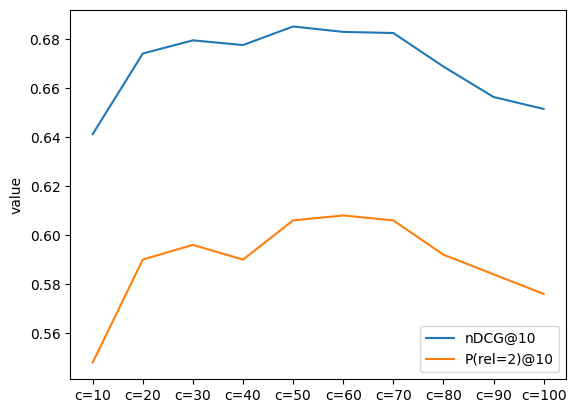

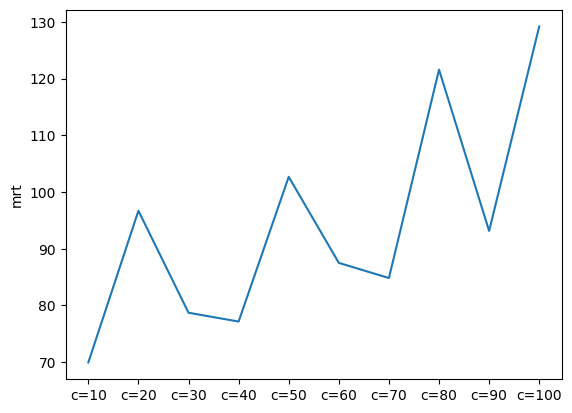

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(res['name'], res['nDCG@10'], label='nDCG@10')
plt.plot(res['name'], res['P(rel=2)@10'], label='P(rel=2)@10')
plt.ylabel('value')
plt.legend()
plt.show()
plt.clf()
plt.plot(res['name'], res['mrt'])
plt.ylabel('mrt')
plt.show()

It appears that the optimal re-ranking threshold for this collection is around 50-70. This also avoids excessive re-ranking time, which grows roughly linearly with larger thredhols. In pratice, this paramter should be tuned on a held-out validation set to avoid over-fitting.

## monoT5

The [monoT5](https://arxiv.org/abs/2003.06713) model scores documents using a causal language model. Let's see how this approach works on TREC COVID.

The `MonoT5ReRanker` class from `pyterrier_t5` automatically loads a version of the monoT5 ranker that is trained on the MS MARCO passage dataset.

In [22]:
from pyterrier_t5 import MonoT5ReRanker
monoT5 = MonoT5ReRanker(text_field='title_abstract')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k s<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M s<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k s<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.84k s<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M s<?, ?B/s]

In [23]:
br = pt.BatchRetrieve(index) % 50
pipeline = (br >> get_title_abstract >> monoT5)
pt.Experiment(
    [br, pipeline],
    dataset.get_topics('description'),
    dataset.get_qrels(),
    names=['DPH', 'DPH >> T5'],
    eval_metrics=[AP(rel=2), nDCG, nDCG@10, P(rel=2)@10, "mrt"]
)

02:16:16.337 [main] WARN org.terrier.structures.FSADocumentIndex - This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


monoT5:   0%|          | 0/625 s<?, ?batches/s]

,name,AP(rel=2),nDCG,nDCG@10,P(rel=2)@10,mrt
0,DPH,0.051738,0.126191,0.642340,0.548,61.831662
1,DPH >> T5,0.059398,0.133929,0.765572,0.660,1940.142151
